In [1]:
# !pip install evaluate

In [2]:
# !pip install nltk

In [3]:
# !pip install rouge_score 

In [4]:
# nltk.download("punkt")

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import evaluate

import nltk
import string
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt

c:\Users\Joan\anaconda3\envs\nlp\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
# Dataset class
class Dataset_Translation(Dataset):
    def __init__(self, lines, word2idx_X=None, word2idx_Y=None):
        # Puctuation and special characters to remove
        punctuation = set(string.punctuation) | set(["'", '”', '“', "’", "‘"])
        # Initialize the lists of input and target sentences
        self.len = len(lines)
        self.X = []
        self.Y = []
        self.vocab_X = set()
        self.vocab_Y = set()
        for line in tqdm(lines):
            # Split the line into input and target strings
            line_splited = line.split('\t')
            # Tokenize the input and target strings
            tokenized_texts = [nltk.word_tokenize(sent) for sent in line_splited[:2]]
            # Remove punctuation
            tokenized_texts = [[word for word in sent if word not in punctuation] for sent in tokenized_texts]
            # Append the tokenized input and target strings to the lists
            self.X.append(tokenized_texts[0])
            self.Y.append(tokenized_texts[1])
            # Update the vocabulary with the new words
            self.vocab_X.update(tokenized_texts[0])
            self.vocab_Y.update(tokenized_texts[1])


        # Adding special tokens to the input and target vocabularies
        self.vocab_X.add('<s>')
        self.vocab_X.add('</s>')
        self.vocab_X.add('<PAD>')
        self.vocab_X.add('<UNK>')

        self.vocab_Y.add('<s>')
        self.vocab_Y.add('</s>')
        self.vocab_Y.add('<PAD>')
        self.vocab_Y.add('<UNK>')

        # Create word2idx dictionaries if not provided
        if word2idx_X is None:
            self.word2idx_X = {word: idx for idx, word in enumerate(sorted(list(self.vocab_X)))}
        else:
            self.word2idx_X = word2idx_X

        if word2idx_Y is None:
            self.word2idx_Y = {word: idx for idx, word in enumerate(sorted(list(self.vocab_Y)))}
        else:
            self.word2idx_Y = word2idx_Y

        # Compute the maximum length of input and target sentences
        self.MAX_LENGTH_out = max([len(y) for y in self.Y])
        self.MAX_LENGTH_in = max([len(x) for x in self.X])

        # Add start, end and padding tokens to the input and target sentences
        for i in range(len(self.X)):
            self.Y[i] = ['<s>'] + self.Y[i] + ['</s>'] + ['<PAD>'] * (self.MAX_LENGTH_out - len(self.Y[i]))
            self.X[i] = ['<PAD>'] * (self.MAX_LENGTH_in - len(self.X[i])) + ['<s>'] + self.X[i] + ['</s>']

        # Convert the input and target sentences to lists of indices
        for i in range(len(self.X)):
            self.X[i] = [self.word2idx_X[word] if word in self.word2idx_X else self.word2idx_X['<UNK>'] for word in self.X[i]]
            self.Y[i] = [self.word2idx_Y[word] if word in self.word2idx_Y else self.word2idx_Y['<UNK>'] for word in self.Y[i]]

        self.X = torch.tensor(self.X)
        self.Y = torch.tensor(self.Y)

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

In [7]:
# Read the data
with open('spa.txt', 'r') as f:
    lines = f.readlines()

# Split the data into train, validation and test sets (80%, 10%, 10%)
train_lines, test_lines = train_test_split(lines, test_size=0.2, random_state=42)
test_lines, val_lines = train_test_split(test_lines, test_size=0.5, random_state=42)

# Create the train dataset
train_dataset = Dataset_Translation(train_lines)

100%|██████████| 102467/102467 [00:29<00:00, 3513.77it/s]


In [8]:
# Create the validation and test datasets, using the vocabulary of the train dataset
test_dataset = Dataset_Translation(test_lines, word2idx_X=train_dataset.word2idx_X, word2idx_Y=train_dataset.word2idx_Y)
val_dataset = Dataset_Translation(val_lines, word2idx_X=train_dataset.word2idx_X, word2idx_Y=train_dataset.word2idx_Y)

100%|██████████| 12809/12809 [00:03<00:00, 3340.63it/s]


In [9]:
# Dataloader class
train_dataloader = DataLoader(train_dataset, batch_size=50, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=50, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=50, shuffle=False)

In [11]:
print("English train vocabulary size:", train_dataset.vocab_X.__len__())
print("Spanish train vocabulary size:", train_dataset.vocab_Y.__len__())

English train vocabulary size: 14167
Spanish train vocabulary size: 27915


In [8]:
# A version of our model without the attention mechanism
class Translator(nn.Module):
    def __init__(self, vocab_size_input, vocab_size_target, target_len, hidden_size=300, n_layers=1, dropout=0.1):
        super(Translator, self).__init__()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.target_len = target_len

        # Initialize the embedding layers
        self.embedding = nn.Embedding(vocab_size_input, hidden_size)
        self.lstm_enc = nn.LSTM(hidden_size, hidden_size, n_layers, batch_first=True)
        self.lstm_dec = nn.LSTM(hidden_size, hidden_size, n_layers, batch_first=True)

        # Initialize the projection layer
        self.projection = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(hidden_size, vocab_size_target)
        )

    def forward(self, input):
        batch_size = input.size(0)
        # Initialize the hidden and cell states
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_size).to(self.device)
        cell = torch.zeros(self.n_layers, batch_size, self.hidden_size).to(self.device)

        # Embed the input  
        embedded = self.embedding(input)
        # Pass the embedded input through the encoder
        _, (hidden, cell) = self.lstm_enc(embedded, (hidden, cell))

        # Initialize the input for the decoder
        inp = torch.zeros(batch_size, self.hidden_size).to(self.device).unsqueeze(1)
        # Initialize the predictions tensor
        pred = self.projection(inp)
        for i in range(self.target_len - 1): # rm <SOS>
            # Pass the input through the decoder
            out, (hidden, cell) = self.lstm_dec(inp, (hidden, cell))

            # Project the output of the decoder and save it in the predictions tensor
            pred = torch.cat((pred, self.projection(out)), dim=1)
            # Update the input of the decoder
            inp = out

        return pred


In [9]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size, decoder_layer, device = 'cuda'):
        super(BahdanauAttention, self).__init__()
        self.hidden_size = hidden_size
        self.decoder_layer = decoder_layer
        self.softmax = nn.Softmax(dim=2)
        self.proj = nn.Linear(self.hidden_size, self.hidden_size)
        self.tanh = nn.Tanh()
        self.hidden_proj = nn.Linear(self.hidden_size, self.hidden_size)
        self.encoder_output_proj = nn.Linear(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(hidden_size, 1)
        self.DEVICE = device

    def forward(self, hidden, encoder_output):
        # hidden -> layers, batch, features
        # encoder_output # batch, time_step, features
        hidden = hidden.permute(1, 2, 0) # batch, features, layers
        addMask = torch.FloatTensor([1/self.decoder_layer] * self.decoder_layer).view(1, self.decoder_layer, 1).to(self.DEVICE)
        addMask = torch.cat([addMask] * hidden.shape[0], dim=0)
        hidden = torch.bmm(hidden, addMask) # batch, feature, 1
        hidden = hidden.permute(0, 2, 1) # batch, 1, features
        hidden_attn = self.hidden_proj(hidden) # b, 1, f
        
        encoder_output_attn = self.encoder_output_proj(encoder_output) # t, b, f
        res_attn = self.tanh(encoder_output_attn + hidden_attn) # b, t, f
        out_attn = self.out(res_attn) # b, t, 1
        out_attn = out_attn.permute(0, 2, 1) # b, 1, t
        out_attn = self.softmax(out_attn) # b, 1, t
        return out_attn

In [10]:
# A version of our model with the attention mechanism, using Bahdanau attention
class Translator_Attention(nn.Module):
    def __init__(self, vocab_size_input, vocab_size_target, target_len, hidden_size=300, n_layers=1, dropout=0.1):
        super(Translator_Attention, self).__init__()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.target_len = target_len

        # Initialize the encoder and decoder
        self.embedding = nn.Embedding(vocab_size_input, hidden_size)
        self.lstm_enc = nn.LSTM(hidden_size, hidden_size, n_layers, batch_first=True)
        self.lstm_dec = nn.LSTM(hidden_size * 2, hidden_size, n_layers, batch_first=True)

        # Initialize the projection layer
        self.projection = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(hidden_size, vocab_size_target)
        )

        # Initialize the attention layer
        self.attention = BahdanauAttention(hidden_size, n_layers, self.device)

    def forward(self, input):
        batch_size = input.size(0)

        # Initialize the hidden and cell states
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_size).to(self.device)
        cell = torch.zeros(self.n_layers, batch_size, self.hidden_size).to(self.device)

        # Embed the input tokens of the encoder
        embedded = self.embedding(input)
        # Pass the embedded tokens through the encoder
        out_enc, (hidden, cell) = self.lstm_enc(embedded, (hidden, cell))

        # Initialize the input of the decoder
        inp = torch.zeros(batch_size, self.hidden_size).to(self.device).unsqueeze(1)
        # Initialize the predictions tensor
        pred = self.projection(inp)
        for i in range(self.target_len - 1): # rm <SOS>
            # Compute the attention weights, given the current hidden state and the encoder output
            attention = self.attention(hidden, out_enc)
            # Compute the attention output
            out_attention = torch.bmm(attention, out_enc) # b, 1, f
            # Concatenate the attention output with the input and pass it through the decoder
            inp = torch.cat((inp, out_attention), dim=2)
            out, (hidden, cell) = self.lstm_dec(inp, (hidden, cell))

            # Project the output of the decoder and save it in the predictions tensor
            pred = torch.cat((pred, self.projection(out)), dim=1)
            # Update the input of the decoder
            inp = out

        return pred


In [11]:
# Initialize the model
model = Translator_Attention(len(train_dataset.vocab_X), len(train_dataset.vocab_Y), train_dataset.MAX_LENGTH_out+2)
model.to(model.device)

Translator_Attention(
  (embedding): Embedding(14167, 300)
  (lstm_enc): LSTM(300, 300, batch_first=True)
  (lstm_dec): LSTM(600, 300, batch_first=True)
  (projection): Sequential(
    (0): Dropout(p=0.1, inplace=False)
    (1): Linear(in_features=300, out_features=27915, bias=True)
  )
  (attention): BahdanauAttention(
    (softmax): Softmax(dim=2)
    (proj): Linear(in_features=300, out_features=300, bias=True)
    (tanh): Tanh()
    (hidden_proj): Linear(in_features=300, out_features=300, bias=True)
    (encoder_output_proj): Linear(in_features=300, out_features=300, bias=True)
    (out): Linear(in_features=300, out_features=1, bias=True)
  )
)

In [18]:
# Loading some metrics for evaluation
meteor = evaluate.load('meteor')
rouge = evaluate.load('rouge')

[nltk_data] Downloading package wordnet to /home/nbiescas/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/nbiescas/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/nbiescas/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [14]:
def compute_metrics(model, dataloader):
    model.eval()
    # Set the target length of the model to the maximum length of the target sentences
    model.target_len = dataloader.dataset.MAX_LENGTH_out + 2 # +2 for <s> and </s>

    special_tokens = {'<s>', '</s>', '<PAD>', '<UNK>'}
    metrics = {"bleu1": 0, "bleu2": 0, "bleu3": 0, "bleu4": 0, "meteor": 0, 'rouge1': 0, 'rouge2': 0, 'rougeL': 0}
    word2idx_Y_inv = np.array([word for word, idx in sorted(dataloader.dataset.word2idx_Y.items(), key=lambda x: x[1])])

    counter = 0
    predictions, references = [], []
    for inputs, targets in tqdm(dataloader):
        with torch.no_grad():
            # Generate the model translations 
            inputs = inputs.to(model.device)
            outputs = model(inputs)
            outputs = outputs.max(2)[1].cpu().numpy()
            targets = targets.cpu().numpy()

            # Convert indices to words and filter out special tokens
            for i in range(inputs.size(0)):
                output_words = word2idx_Y_inv[outputs[i]]
                target_words = word2idx_Y_inv[targets[i]]

                output_sentence = ' '.join([word for word in output_words if word not in special_tokens])
                target_sentence = ' '.join([word for word in target_words if word not in special_tokens])

                predictions.append(output_sentence)
                references.append(target_sentence)

                counter += 1

    # Compute metrics
    metrics["bleu1"] = np.mean([nltk.translate.bleu_score.sentence_bleu([ref], pred, weights=(1, 0, 0, 0)) for pred, ref in zip(predictions, references)])
    metrics["bleu2"] = np.mean([nltk.translate.bleu_score.sentence_bleu([ref], pred, weights=(0, 1, 0, 0)) for pred, ref in zip(predictions, references)])
    metrics["bleu3"] = np.mean([nltk.translate.bleu_score.sentence_bleu([ref], pred, weights=(0, 0, 1, 0)) for pred, ref in zip(predictions, references)])
    metrics["bleu4"] = np.mean([nltk.translate.bleu_score.sentence_bleu([ref], pred, weights=(0, 0, 0, 1)) for pred, ref in zip(predictions, references)])
    metrics["meteor"] = np.mean([meteor.compute(predictions=[pred], references=[ref])["meteor"] for pred, ref in zip(predictions, references)])
    rouge_scores = rouge.compute(predictions=predictions, references=references)
    metrics['rouge1'] = rouge_scores['rouge1']
    metrics['rouge2'] = rouge_scores['rouge2']
    metrics['rougeL'] = rouge_scores['rougeL']


    return metrics


In [ ]:
# Define the optimizer and loss function
optimizer = optim.AdamW(model.parameters())
criterion = nn.CrossEntropyLoss()

# Set the number of epochs
num_epochs = 10

best_val_meteor = 0
meteor_hist = []
loss_hist = []
metrics_hist = []

# Training loop
for epoch in range(num_epochs):
    running_loss = 0.0
    model.train()
    model.target_len = train_dataloader.dataset.MAX_LENGTH_out+2
    for inputs, targets in tqdm(train_dataloader):
        inputs = inputs.to(model.device)
        targets = targets.to(model.device)
        # Zero the gradients
        optimizer.zero_grad()
        # Forward pass
        outputs = model(inputs)
        outputs = outputs.permute(0, 2, 1)
        # Compute the loss
        loss = criterion(outputs, targets)
        # Backward pass
        loss.backward()
        # Update the weights
        optimizer.step()

        # Update the running loss
        running_loss += loss.item()

    # Print the average loss for the epoch
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_dataloader)}")
    loss_hist.append(running_loss/len(train_dataloader))

    # Evaluate on validation set
    metrics = compute_metrics(model, val_dataloader)
    print("Validation metrics:", metrics)
    meteor_hist.append(metrics["meteor"])
    metrics_hist.append(metrics)

    # Save the model if the METEOR score on the validation set is the best
    if metrics["meteor"] > best_val_meteor:
        torch.save(model.state_dict(), f'best_model_{epoch + 1}.pth')


In [34]:
# Training for 5 more epochs
num_epochs = 5
for epoch in range(num_epochs):
    running_loss = 0.0
    model.train()
    model.target_len = train_dataloader.dataset.MAX_LENGTH_out+2
    for inputs, targets in tqdm(train_dataloader):
        inputs = inputs.to(model.device)
        targets = targets.to(model.device)
        # Zero the gradients
        optimizer.zero_grad()
        # Forward pass
        outputs = model(inputs)
        outputs = outputs.permute(0, 2, 1)
        # Compute the loss
        loss = criterion(outputs, targets)
        # Backward pass
        loss.backward()
        # Update the weights
        optimizer.step()

        # Update the running loss
        running_loss += loss.item()

    # Print the average loss for the epoch
    print(f"Epoch {epoch+11}/{num_epochs+10}, Loss: {running_loss/len(train_dataloader)}")
    loss_hist.append(running_loss/len(train_dataloader))

    # Evaluate on validation set
    metrics = compute_metrics(model, val_dataloader)
    print("Validation metrics:", metrics)
    meteor_hist.append(metrics["meteor"])
    metrics_hist.append(metrics)
    
    # Save the model if the METEOR score on the validation set is the best
    if metrics["meteor"] > best_val_meteor:
        torch.save(model.state_dict(), f'best_model_{epoch + 11}.pth')

    

100%|██████████| 2050/2050 [08:19<00:00,  4.11it/s]


Epoch 11/15, Loss: 0.2058908845157158


100%|██████████| 257/257 [00:13<00:00, 18.95it/s]


Validation metrics: {'bleu1': 0.6993877133234241, 'bleu2': 0.5837430599144677, 'bleu3': 0.5188332311494407, 'bleu4': 0.4678622332512838, 'meteor': 0.49324649254645786, 'rouge1': 0.597123259912764, 'rouge2': 0.36109607350027584, 'rougeL': 0.5851935191785256}


100%|██████████| 2050/2050 [08:21<00:00,  4.09it/s]


Epoch 12/15, Loss: 0.19627910326530293


100%|██████████| 257/257 [00:13<00:00, 19.50it/s]


Validation metrics: {'bleu1': 0.6988673226655021, 'bleu2': 0.5840129031555201, 'bleu3': 0.5196147794867346, 'bleu4': 0.4689793343090851, 'meteor': 0.4960412590626761, 'rouge1': 0.5989090562298098, 'rouge2': 0.36380280725010505, 'rougeL': 0.5873356933866227}


100%|██████████| 2050/2050 [08:28<00:00,  4.03it/s]


Epoch 13/15, Loss: 0.1890498272202364


100%|██████████| 257/257 [00:13<00:00, 18.50it/s]


Validation metrics: {'bleu1': 0.6976155014564799, 'bleu2': 0.5833032633659269, 'bleu3': 0.5191854005012492, 'bleu4': 0.46879270337672685, 'meteor': 0.493368489399965, 'rouge1': 0.5972180855364536, 'rouge2': 0.36134332662370083, 'rougeL': 0.5858619651456451}


100%|██████████| 2050/2050 [07:40<00:00,  4.46it/s]


Epoch 14/15, Loss: 0.18242032757256088


100%|██████████| 257/257 [00:12<00:00, 21.22it/s]


Validation metrics: {'bleu1': 0.7011401428859152, 'bleu2': 0.5873402348011867, 'bleu3': 0.5230249529502093, 'bleu4': 0.47235303589300764, 'meteor': 0.49714901254505856, 'rouge1': 0.6009595689995861, 'rouge2': 0.3649688377828775, 'rougeL': 0.5889221398164706}


100%|██████████| 2050/2050 [07:36<00:00,  4.49it/s]


Epoch 15/15, Loss: 0.17645288528829087


100%|██████████| 257/257 [00:12<00:00, 21.24it/s]


Validation metrics: {'bleu1': 0.7002767961627033, 'bleu2': 0.586143534041403, 'bleu3': 0.5217087006152467, 'bleu4': 0.47067459944795753, 'meteor': 0.4970674162547454, 'rouge1': 0.6001563107288602, 'rouge2': 0.3635874411951917, 'rougeL': 0.588504768218338}


In [24]:
metrics_hist[0].keys()

dict_keys(['bleu1', 'bleu2', 'bleu3', 'bleu4', 'meteor', 'rouge1', 'rouge2', 'rougeL'])

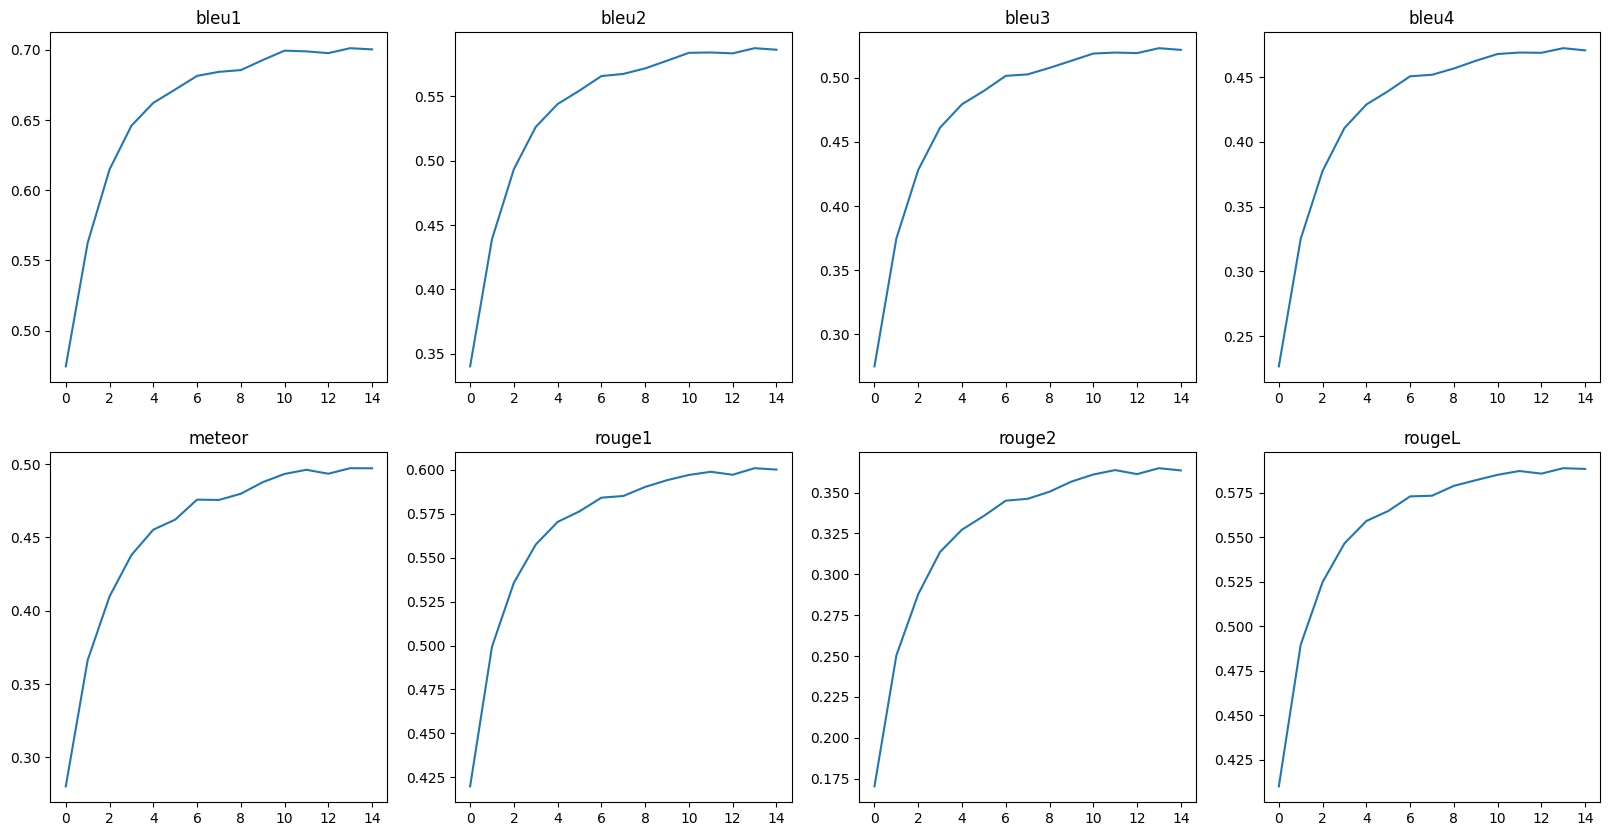

In [35]:
# Obtaining a list of all the validation metrics for each epoch
results_complete = {key: [] for key in metrics_hist[0].keys()}
for metrics in metrics_hist:
    for key in metrics:
        results_complete[key].append(metrics[key])

# Do a subplot for each metric
fig, axs = plt.subplots(2, 4, figsize=(20, 10))
for i, key in enumerate(results_complete.keys()):
    axs[i//4, i%4].plot(results_complete[key])
    axs[i//4, i%4].set_title(key)

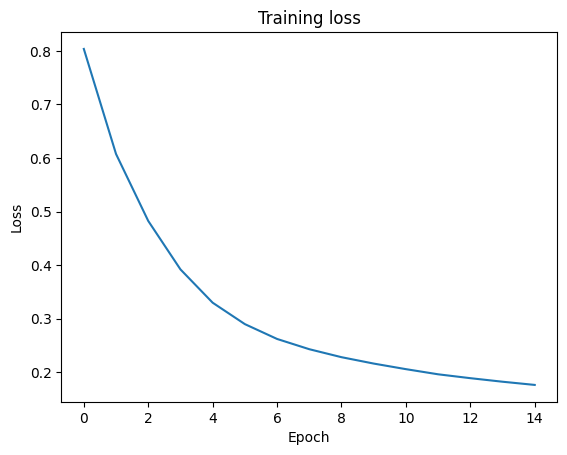

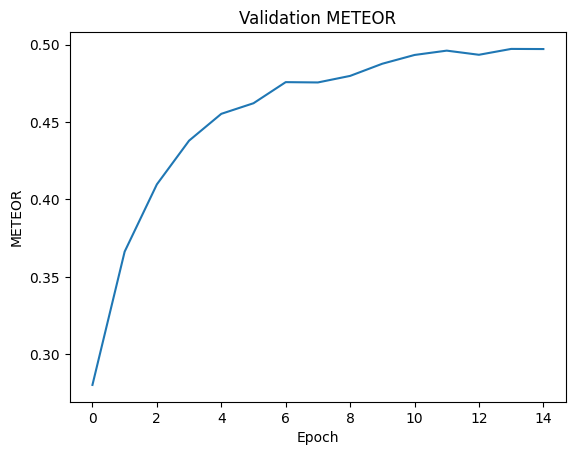

In [36]:
plt.plot(loss_hist)
plt.title('Training loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

plt.plot(meteor_hist)
plt.title('Validation METEOR')
plt.xlabel('Epoch')
plt.ylabel('METEOR')
plt.show()

In [37]:
# Load the best model
model.load_state_dict(torch.load('best_model_15.pth'))

<All keys matched successfully>

In [38]:
# Evaluating on the test set
compute_metrics(model, test_dataloader)

100%|██████████| 257/257 [00:23<00:00, 11.14it/s]


{'bleu1': 0.703852573802549,
 'bleu2': 0.5892827048085753,
 'bleu3': 0.5242938133038587,
 'bleu4': 0.47317917882890975,
 'meteor': 0.498231652719249,
 'rouge1': 0.6011584955891944,
 'rouge2': 0.36476673641617585,
 'rougeL': 0.5884960045471284}

In [39]:
def show_examples(model, dataloader, num_examples):
    model.eval()
    counter_examples = 0
    special_tokens = ['<s>', '</s>', '<PAD>', '<UNK>']
    word2idx_Y_inv = {idx: word for word, idx in dataloader.dataset.word2idx_Y.items()}
    word2idx_X_inv = {idx: word for word, idx in dataloader.dataset.word2idx_X.items()}

    for inputs, targets in dataloader:
        with torch.no_grad():
            # Generate the model translations
            batch_size = inputs.size(0)
            inputs = inputs.to(model.device)
            outputs = model(inputs)
            outputs = outputs.max(2)[1]

            outputs = outputs.cpu().numpy()
            targets = targets.cpu().numpy()
            inputs = inputs.cpu().numpy()

            # Iterate over the batch
            for i in range(batch_size):
                # Convert indices to words and filter out special tokens
                outputs_i = outputs[i]
                targets_i = targets[i]
                inputs_i = inputs[i]

                outputs_i = [word2idx_Y_inv[idx] for idx in outputs_i]
                targets_i = [word2idx_Y_inv[idx] for idx in targets_i]
                inputs_i = [word2idx_X_inv[idx] for idx in inputs_i]

                outputs_i = [word for word in outputs_i if word not in special_tokens]
                targets_i = [word for word in targets_i if word not in special_tokens]
                inputs_i = [word for word in inputs_i if word not in special_tokens]

                targets_i = ' '.join(targets_i)
                outputs_i = ' '.join(outputs_i)
                inputs_i = ' '.join(inputs_i)

                print("Original:", inputs_i)
                print("Target:", targets_i)
                print("Prediction:", outputs_i)
                print()
                counter_examples += 1
                # Stop if we have shown the desired number of examples
                if counter_examples == num_examples:
                    return

show_examples(model, test_dataloader, num_examples=30)

Original: How many other guys named Tom do you know
Target: ¿A cuántos otros sujetos de nombre Tom conoces
Prediction: ¿Cuántos Tom Tom Tom Tom sabés

Original: I want one
Target: ¡Quiero una
Prediction: Quiero uno

Original: Tom has been convicted of drunken driving twice in the last four years
Target: Tom fue condenado por conducir en estado de ebriedad dos veces en los últimos cuatro años
Prediction: Tom ha estado condenado de conducción de de efectos efectos efectos efectos veces de últimos últimos últimos años años

Original: Perhaps Tom wo n't go to Boston
Target: Puede que Tom no vaya a Boston
Prediction: Quizá Tom no se a a Boston

Original: I 've been patient my whole life
Target: He sido paciente toda mi vida
Prediction: He toda paciente vida mi vida

Original: Some things are better left undone
Target: Algunas cosas es mejor sin hacer
Prediction: Algunas cosas son mejores se

Original: Have you understood everything
Target: ¿Has entendido todo
Prediction: ¿Has todo todo

Ori